CS470 Assignment #1: CNN classification with Cifar10
====

Primary TA : Myeongjae Jang

TA's E-mail : myeongjae0409@kaist.ac.kr

## Instruction

- Modify the baseline CNN model to improve the classification performance on Cifar10 dataset. In addition to the model definition, you can modify any parts of this colab example to improve the test accuracy (e.g., learning rate, batch size, etc.)
- Train your CNN model and compare it to the baseline (in terms of training loss and the test accuracy).
- Explain your modifications and discuss how you improved the test accuracy.

## Submission guidelines

- Your code and report will be all in Colab. Copy this example to your google drive and edit it to complete your assignment. Add sections at the bottom of this example to discuss the results. For discussion and analysis, we highly encourage you to use graphics if possible (e.g., plots, images, etc.). 
- To make grading efficient, please highlight all contributions & modifications you made clearly. We highly encourage you to add code blocks in the discussion section to discuss your modifications (e.g., you can describe the model definition in the discussion section using the code blocks).
- We should be able to reproduce your results using your code and pre-trained model. Please double-check if your code runs without error and loads your pre-trained model properly. Submissions failed to run or reproduce the results will get a substantial penalty. 
- In this assignment, **we are not allowing fine-tuning from the pre-trained model** (e.g. ImageNet pre-trained models). You should train your  model on Cifar10 dataset from scratch. 

## Deliverables
- Download your Colab notebook and the pre-trained model, and submit a zip file in a format: [StudentID].zip. Please double-check that you locate and load your pre-trained model properly.
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions. 

## Grading policy

- **Code** (50%): Your code should work and outperform the baseline model in terms of the test accuracy. 
- **Report** (50%): Explain your modification and justify how it improved the perofrmance. It would be great if you have some supporting results for your justification (e.g., justifying that you resolved the overfitting by comparing two training/testing loss curves). 
- **Extra points** will be given if your submission satisfies the following:
 - **High test accuracy**: we will rank the submissions based on the test accuracy, and assign extra points according to the rank (e.g. 3 points for top 10%, 2 points for top 30%, 1 points for top 50%.)
 - **Comprehensive discussion**: we will assign extra points if your report contains comprehensive discussion/analysis of the results. Examples include justification of your choice of model (or hyper-parameters), comparisons to the baseline model (analysis on the source of improvement), insightful visualizations (loss curves, misclassification results), etc.

## Due date
- **23:59:59 September 25th.**
- Late submission is allowed until 23:59:59 September 27th.
- Late submission will be applied 20% penalty.

## Questions
- Please use QnA board in KLMS as a main communication channel. When you post questions, please make it public so that all students can share the information. Please use the prefix "[Assignment 1]" in the subject for all questions regarding this assignment (e.g., [Assignment 1] Regarding the grading policy).

## PyTorch Documentation
- You can refer PyTorch documentation for your assignment.
- https://pytorch.org/docs/stable/index.html



## Step 1: Connect to your Google Drive

It is required if you want to save checkpoints and load them later on.

### (You have to submit your trained results as the checkpoint. So, please check your Google Drive connection again.)

In [1]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Step 2: Import modules

In [2]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

!pip install -U tensorboardcolab
from tensorboardcolab import TensorBoardColab

torch.manual_seed(470)
torch.cuda.manual_seed(470)

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


Using TensorFlow backend.


## Step 3: Configure the experiments

In [19]:
# training & optimization hyper-parameters
max_epoch = 20
learning_rate = 0.001

# My modification
# batch_size = 20000 <--- Original code
batch_size = 18

device = 'cuda'

# model hyper-parameters
output_dim = 10 

# Boolean value to select training process
training_process = True

# initialize tensorboard for visualization
# Note : click the Tensorboard link to see the visualization of training/testing results
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://24e99c67.ngrok.io


## Step 4: Construct data pipeline

**`torchvision.datasets.CIFAR10`** will automatically construct **`Cifar10`** dataset.

In [20]:
data_dir = os.path.join(gdrive_root, 'my_data')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Step 5: Construct a neural network builder

We serve the baseline CNN model which is supported on Pytorch tutorial: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb#scrollTo=c1E1b7-igUcR

### (You have to compare your own CNN model's test accuracy with the baseline CNN model and explain why your own model's test accuracy is higher than the basline.)

In [0]:
class MyClassifier(nn.Module):
  def __init__(self):
        super(MyClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.batchnorm1 = nn.BatchNorm2d(num_features=6)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(num_features=32)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1)
        self.fc1 = nn.Linear(in_features=64 * 1 * 1, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=output_dim)

  def forward(self, x):
      x = self.pool(self.relu(self.batchnorm1(self.conv1(x))))
      x = self.pool(self.relu(self.conv2(x)))
      x = self.pool(self.relu(self.batchnorm3(self.conv3(x))))
      x = self.pool(self.relu(self.conv4(x)))
      x = x.view(-1, 64 * 1 * 1)
      x = self.relu(self.fc1(x))
      outputs = self.fc2(x)
      return outputs

## Step 6: Initialize the network and optimizer

If you want to train modularized neural network in Step 5B, please use 'MyClassifier2' as 'my_classifier'. It is written as a comment now.

In [6]:
my_classifier = MyClassifier()
my_classifier = my_classifier.to(device)

# Print your neural network structure
print(my_classifier)

optimizer = optim.Adam(my_classifier.parameters(), lr=learning_rate)


MyClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


## Step 7: Load pre-trained weights if exist

- **For your submission you have to store the trained model as a checkpoint.**
- Please do not erase this step.
- If you want to modify this step, please be careful.
- After training please confirm that your checkpoint is correctly stored and re-loaded.

In [22]:
ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
best_acc = 0.
ckpt_path = os.path.join(ckpt_dir, 'lastest.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    my_classifier.load_state_dict(ckpt['my_classifier'])
    optimizer.load_state_dict(ckpt['optimizer'])
    best_acc = ckpt['best_acc']
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best accuracy : %.2f' % best_acc)

checkpoint is loaded !
current best accuracy : 0.84


## Step 8: Train the network

Note : It would be better to save checkpoints periodically, otherwise you'll lose everything you've trained if the session is recycled.

In [8]:
if training_process:
  it = 0
  train_losses = []
  test_losses = []
  for epoch in range(max_epoch):
    # train phase
    my_classifier.train()
    for inputs, labels in train_dataloader:
      it += 1

      # load data to the GPU.
      inputs = inputs.to(device)
      labels = labels.to(device)

      # feed data into the network and get outputs.
      logits = my_classifier(inputs)

      # calculate loss
      # Note: `F.cross_entropy` function receives logits, or pre-softmax outputs, rather than final probability scores.
      loss = F.cross_entropy(logits, labels)

      # Note: You should flush out gradients computed at the previous step before computing gradients at the current step. 
      #       Otherwise, gradients will accumulate.
      optimizer.zero_grad()

      # backprogate loss.
      loss.backward()

      # update the weights in the network.
      optimizer.step()

      # calculate accuracy.
      acc = (logits.argmax(dim=1) == labels).float().mean()

      if it % 2000 == 0:
        tbc.save_value('Loss', 'train_loss', it, loss.item())
        print('[epoch:{}, iteration:{}] train loss : {:.4f} train accuracy : {:.4f}'.format(epoch, it, loss.item(), acc.item()))

    # save losses in a list so that we can visualize them later.
    train_losses.append(loss)  

    # test phase
    n = 0.
    test_loss = 0.
    test_acc = 0.
    my_classifier.eval()
    for test_inputs, test_labels in test_dataloader:
      test_inputs = test_inputs.to(device)
      test_labels = test_labels.to(device)

      logits = my_classifier(test_inputs)
      test_loss += F.cross_entropy(logits, test_labels, reduction='sum').item()
      test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
      n += inputs.size(0)

    test_loss /= n
    test_acc /= n
    test_losses.append(test_loss)
    tbc.save_value('Loss', 'test_loss', it, test_loss)
    print('[epoch:{}, iteration:{}] test_loss : {:.4f} test accuracy : {:.4f}'.format(epoch, it, test_loss, test_acc)) 

    tbc.flush_line('train_loss')
    tbc.flush_line('test_loss')

    # save checkpoint whenever there is improvement in performance
    if test_acc > best_acc:
      best_acc = test_acc
      # Note: optimizer also has states ! don't forget to save them as well.
      ckpt = {'my_classifier':my_classifier.state_dict(),
              'optimizer':optimizer.state_dict(),
              'best_acc':best_acc}
      torch.save(ckpt, ckpt_path)
      print('checkpoint is saved !')
    
tbc.close()



[epoch:0, iteration:2000] train loss : 1.3674 train accuracy : 0.4444
[epoch:0, iteration:2778] test_loss : 1.3600 test accuracy : 0.8165
[epoch:1, iteration:4000] train loss : 0.8239 train accuracy : 0.6667
[epoch:1, iteration:5556] test_loss : 1.3395 test accuracy : 0.8246
[epoch:2, iteration:6000] train loss : 0.8786 train accuracy : 0.6111
[epoch:2, iteration:8000] train loss : 0.8532 train accuracy : 0.7778
[epoch:2, iteration:8334] test_loss : 1.3374 test accuracy : 0.8234
[epoch:3, iteration:10000] train loss : 0.7807 train accuracy : 0.7222
[epoch:3, iteration:11112] test_loss : 1.3282 test accuracy : 0.8263
[epoch:4, iteration:12000] train loss : 0.3357 train accuracy : 0.8889
[epoch:4, iteration:13890] test_loss : 1.3403 test accuracy : 0.8262
[epoch:5, iteration:14000] train loss : 1.1688 train accuracy : 0.7222
[epoch:5, iteration:16000] train loss : 0.8268 train accuracy : 0.6111
[epoch:5, iteration:16668] test_loss : 1.3433 test accuracy : 0.8291
[epoch:6, iteration:180

## Step 9: Visualize and analyze the results

Test_loss : 1.3472, Test accuracy : 0.8270


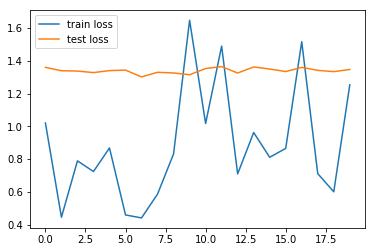

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

# Re-load trained model
my_classifier.load_state_dict(ckpt['my_classifier'])
optimizer.load_state_dict(ckpt['optimizer'])

# Testing
n = 0.
test_loss = 0.
test_acc = 0.
my_classifier.eval()
for test_inputs, test_labels in test_dataloader:
  test_inputs = test_inputs.to(device)
  test_labels = test_labels.to(device)

  logits = my_classifier(test_inputs)
  test_loss += F.cross_entropy(logits, test_labels, reduction='sum')
  test_acc += (logits.argmax(dim=1) == test_labels).float().sum()
  n += inputs.size(0)

test_loss /= n
test_acc /= n
print('Test_loss : {:.4f}, Test accuracy : {:.4f}'.format(test_loss.item(), test_acc.item())) 

label : ship
prediction : ship


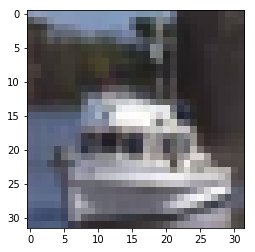

In [18]:
import random

import matplotlib.pyplot as plt
import numpy as np

my_classifier.eval()

num_test_samples = len(test_dataset)
random_idx = random.randint(0, num_test_samples)

test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(my_classifier(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %s' % classes[test_label])
print('prediction : %s' % classes[test_prediction])

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(test_input))

# <font color="blue"> Discussion and Analysis </font>

First, let us briefly summarize/analyze our baseline model.

This part is where the experiment is configured i.e. where the training/optimization/model hyper-parameters are set.

Note that our batch_size (to be used in our batch learning later on.) is huge - 20000.

In [0]:
# training & optimization hyper-parameters
max_epoch = 20
learning_rate = 0.001
batch_size = 20000
device = 'cuda'

# model hyper-parameters
output_dim = 10 

# Boolean value to select training process
training_process = True

# initialize tensorboard for visualization
# Note : click the Tensorboard link to see the visualization of training/testing results
tbc = TensorBoardColab()

This is the given baseline CNN architecture.

In [0]:
class MyClassifier(nn.Module):
  def __init__(self):
        super(MyClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.batchnorm1 = nn.BatchNorm2d(num_features=6)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(num_features=32)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1)
        self.fc1 = nn.Linear(in_features=64 * 1 * 1, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=output_dim)

  def forward(self, x):
      x = self.pool(self.relu(self.batchnorm1(self.conv1(x))))
      x = self.pool(self.relu(self.conv2(x)))
      x = self.pool(self.relu(self.batchnorm3(self.conv3(x))))
      x = self.pool(self.relu(self.conv4(x)))
      x = x.view(-1, 64 * 1 * 1)
      x = self.relu(self.fc1(x))
      outputs = self.fc2(x)
      return outputs

Lastly, this is the part where the network and optimizer is initialized.

Note that we are using Adam as our optimizer. Adam is "an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments." ("Adam: A Method for Stochastic Optimization") (*Kingma, Ba*)

In [0]:
my_classifier = MyClassifier()
my_classifier = my_classifier.to(device)

# Print your neural network structure
print(my_classifier)

optimizer = optim.Adam(my_classifier.parameters(), lr=learning_rate)


This baseline model gave a test accuracy of about 0.62 where the accuracies and the graph of training/test loss came out as the following:

[epoch:0, iteration:3] test_loss : 1.0157 test accuracy : 0.6521

[epoch:1, iteration:6] test_loss : 1.0145 test accuracy : 0.6521

[epoch:2, iteration:9] test_loss : 1.0142 test accuracy : 0.6501

[epoch:3, iteration:12] test_loss : 1.0136 test accuracy : 0.6487

[epoch:4, iteration:15] test_loss : 1.0120 test accuracy : 0.6485

[epoch:5, iteration:18] test_loss : 1.0099 test accuracy : 0.6491

[epoch:6, iteration:21] test_loss : 1.0073 test accuracy : 0.6509

[epoch:7, iteration:24] test_loss : 1.0049 test accuracy : 0.6522

[epoch:8, iteration:27] test_loss : 1.0030 test accuracy : 0.6530

[epoch:9, iteration:30] test_loss : 1.0015 test accuracy : 0.6523

[epoch:10, iteration:33] test_loss : 1.0005 test accuracy : 0.6530

[epoch:11, iteration:36] test_loss : 0.9997 test accuracy : 0.6535

[epoch:12, iteration:39] test_loss : 0.9991 test accuracy : 0.6529

[epoch:13, iteration:42] test_loss : 0.9987 test accuracy : 0.6534

[epoch:14, iteration:45] test_loss : 0.9984 test accuracy : 0.6536

[epoch:15, iteration:48] test_loss : 0.9981 test accuracy : 0.6536

[epoch:16, iteration:51] test_loss : 0.9979 test accuracy : 0.6542

[epoch:17, iteration:54] test_loss : 0.9976 test accuracy : 0.6543

[epoch:18, iteration:57] test_loss : 0.9975 test accuracy : 0.6542

[epoch:19, iteration:60] test_loss : 0.9976 test accuracy : 0.6549

<figure>
<center>
<img src='https://i.gyazo.com/d17c7bb9b1786b41f8d88ae8d5cd785a.png'/>
<figcaption>Epoch vs. Accuracy (Batch size: 20000)</figcaption></center>

Now here comes the modification part.

Surprisingly, the only modification that I've done to the model was to change the **batch_size** from 20000 (original value) to 18; no change to the basline CNN architecture, no change to learning rate...etc.

In [0]:
# training & optimization hyper-parameters
max_epoch = 20
learning_rate = 0.001

# My modification
# batch_size = 20000 <--- Original code
batch_size = 18

device = 'cuda'

# model hyper-parameters
output_dim = 10 

# Boolean value to select training process
training_process = True

# initialize tensorboard for visualization
# Note : click the Tensorboard link to see the visualization of training/testing results
tbc = TensorBoardColab()

This gave a test accuracy of about 0.84 where the accuracies and the graph of training/test loss came out as the following:

[epoch:0, iteration:2000] train loss : 1.3674 train accuracy : 0.4444

[epoch:0, iteration:2778] test_loss : 1.3600 test accuracy : 0.8165

[epoch:1, iteration:4000] train loss : 0.8239 train accuracy : 0.6667

[epoch:1, iteration:5556] test_loss : 1.3395 test accuracy : 0.8246

[epoch:2, iteration:6000] train loss : 0.8786 train accuracy : 0.6111

[epoch:2, iteration:8000] train loss : 0.8532 train accuracy : 0.7778

[epoch:2, iteration:8334] test_loss : 1.3374 test accuracy : 0.8234

[epoch:3, iteration:10000] train loss : 0.7807 train accuracy : 0.7222

[epoch:3, iteration:11112] test_loss : 1.3282 test accuracy : 0.8263

[epoch:4, iteration:12000] train loss : 0.3357 train accuracy : 0.8889

[epoch:4, iteration:13890] test_loss : 1.3403 test accuracy : 0.8262

[epoch:5, iteration:14000] train loss : 1.1688 train accuracy : 0.7222

[epoch:5, iteration:16000] train loss : 0.8268 train accuracy : 0.6111

[epoch:5, iteration:16668] test_loss : 1.3433 test accuracy : 0.8291

[epoch:6, iteration:18000] train loss : 0.7550 train accuracy : 0.7222

[epoch:6, iteration:19446] test_loss : 1.3016 test accuracy : 0.8370

checkpoint is saved !

[epoch:7, iteration:20000] train loss : 0.6013 train accuracy : 0.8333

[epoch:7, iteration:22000] train loss : 1.0191 train accuracy : 0.6111

[epoch:7, iteration:22224] test_loss : 1.3300 test accuracy : 0.8326

[epoch:8, iteration:24000] train loss : 0.5541 train accuracy : 0.7778

[epoch:8, iteration:25002] test_loss : 1.3258 test accuracy : 0.8295

[epoch:9, iteration:26000] train loss : 0.8931 train accuracy : 0.7222

[epoch:9, iteration:27780] test_loss : 1.3150 test accuracy : 0.8289

[epoch:10, iteration:28000] train loss : 1.0763 train accuracy : 0.7222

[epoch:10, iteration:30000] train loss : 1.0155 train accuracy : 0.6667

[epoch:10, iteration:30558] test_loss : 1.3530 test accuracy : 0.8221

[epoch:11, iteration:32000] train loss : 1.1474 train accuracy : 0.6667

[epoch:11, iteration:33336] test_loss : 1.3648 test accuracy : 0.8231

[epoch:12, iteration:34000] train loss : 0.7002 train accuracy : 0.7222

[epoch:12, iteration:36000] train loss : 0.5949 train accuracy : 0.8889

[epoch:12, iteration:36114] test_loss : 1.3255 test accuracy : 0.8334

[epoch:13, iteration:38000] train loss : 0.7354 train accuracy : 0.7222

[epoch:13, iteration:38892] test_loss : 1.3626 test accuracy : 0.8240

[epoch:14, iteration:40000] train loss : 0.6993 train accuracy : 0.7222

[epoch:14, iteration:41670] test_loss : 1.3499 test accuracy : 0.8253

[epoch:15, iteration:42000] train loss : 0.7942 train accuracy : 0.6667

[epoch:15, iteration:44000] train loss : 0.4864 train accuracy : 0.8333

[epoch:15, iteration:44448] test_loss : 1.3345 test accuracy : 0.8295

[epoch:16, iteration:46000] train loss : 0.6438 train accuracy : 0.7222

[epoch:16, iteration:47226] test_loss : 1.3599 test accuracy : 0.8282

[epoch:17, iteration:48000] train loss : 1.4730 train accuracy : 0.4444

[epoch:17, iteration:50000] train loss : 0.8576 train accuracy : 0.7778

[epoch:17, iteration:50004] test_loss : 1.3419 test accuracy : 0.8261

[epoch:18, iteration:52000] train loss : 1.0811 train accuracy : 0.6111

[epoch:18, iteration:52782] test_loss : 1.3340 test accuracy : 0.8285

[epoch:19, iteration:54000] train loss : 1.0884 train accuracy : 0.5000

[epoch:19, iteration:55560] test_loss : 1.3472 test accuracy : 0.8270



<figure>
<center>
<img src='https://i.gyazo.com/c3baa3799370374d1456fc6d896dde0b.png'/>
<figcaption>Epoch vs. Accuracy (Batch size: 18)</figcaption></center>

And it turned out that the accuracy in this case exceeded all the other trials that I have done such as trying to change the CNN architecture by adding layers or changing the parameters of each layer.

(The order of how I've done this assignment is, admittedly, a bit unorthodox. But I would argue that this is the very result of empirical trials. An analysis and the direction of further studies are outlined below.)

# Analysis

Rather than focusing on the CNN architecture and how to change it (as you might've expected for me to do), I would like to focus on the effect of the size of batch on the accuracy and the model.

The metric that I'll use to describe the effect of batch size on training dynamics is the **generalization gap**: the difference between the classfication accuracy at test and training steps.

Batch learning was introduced to take into account the limited avenue for parallelization for original stochastic gradient methods. As shown in [4], practicing deep-learning people observed that *the generalization gap is rather big when trained with large-batch methods rather than small-batch methods*. But it has not yet been theoretically proven of why this is the case.

Several researches have been carried out relating to the effect of batch size on the performance of certain model in Deep Learning. One of them, [3], proposed the following conjectures for possible causes of such phenomenon:


1.   Large-batch methods overfit the model
2.   Large-batch methods are attracted to saddle points
3.   Large-batch methods lack the *explorative* properties of small-batch methods and tend to zoom-in on the minimizer closest to the initial point.
4.   Small-batch and large-batch methods converge to qualitatively different minimizers with differing generalization properties.

And they actually presented some datas that seem to support the last two conjectures.

The following is the main observation of this paper, and the reason why this little modification made such a big difference in model accuracy:

The lack of generalization ability is due to the fact that **large-batch methods tend to convergen to sharp minimizers of the training function** while **small-batch methods tend to convergen to flat minimizers of the training function**

*   *Sharp minimizers* are characterized by a significant number of large positive eigenvalues in the Hessian of the training function, and tend to generalize less well as shown in the diagram.
*   *Flat minimizers* are characterized by a significant number of small eigenvalues in the Hessian of the training function, and tend to generalize  well, as shown in the diagram.

They have observed that the loss function landscape of deep neural networks, such as our CNN, is such that large-batch methods are attracted to regions with sharp minimizers and that, unlike small-batch methods, are unable to escape basins of attraction of these minimizers.

<a href="https://gyazo.com/a5d8f5f470c196619a7ba6b8e5417dff"><img src="https://i.gyazo.com/a5d8f5f470c196619a7ba6b8e5417dff.png" alt="Image from Gyazo" width="598"/></a>

Note that flat minimizer can be specified with lower precision than to sharp minimizer. Equivalently, flat minimizers tend to have better generalization performance.

Following is the result of the experiments done in the paper. For all experiments, they've used 10% of the training data as the large-batch size and 256 data points for small-batch size. Also, they've used ADAM optimizer, the same as our model's optimizer.

<a href="https://gyazo.com/19441b359b46f7fa990816cab4ad9f97"><img src="https://i.gyazo.com/19441b359b46f7fa990816cab4ad9f97.png" alt="Image from Gyazo" width="586"/></a>

<a href="https://gyazo.com/16788fc2c402a6c56aae8aefdaf0356b"><img src="https://i.gyazo.com/16788fc2c402a6c56aae8aefdaf0356b.png" alt="Image from Gyazo" width="593"/></a>

<a href="https://gyazo.com/6253804bdbca58040bcc27aed39a8dcd"><img src="https://i.gyazo.com/6253804bdbca58040bcc27aed39a8dcd.png" alt="Image from Gyazo" width="591"/></a>

(Here, SB refers to the small-batch method and LB refers to the large-batch method)

Above paper([3]), what I think, is the main reason for the drastic improvement of the performance of my model despite having only changed the batch size.

# References / Further Readings
[1] https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

[2] https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network

[3] https://arxiv.org/pdf/1609.04836.pdf ("On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima") (*Keskar, Mudigere, Nocedal, Smelyanskiy, Tang*)

[4] https://cseweb.ucsd.edu/classes/wi08/cse253/Handouts/lecun-98b.pdf ("Efficient Backdrop") (*LeCun, Bottou, Orr, Muller*)